In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender

  Created wheel for colabgymrender: filename=colabgymrender-1.0.8-cp37-none-any.whl size=2511 sha256=4b58b010a37be8e64293f0a18959555c3d2ad2de31c8233ce1cfd5a1a291315a
  Stored in directory: /root/.cache/pip/wheels/8a/d1/e8/ef1d4f6e536cc6b965b28c859ccd2a7f7ab123b94ef4007712
Successfully built colabgymrender


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import random
import os
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from torchvision import transforms
from colabgymrender.recorder import Recorder
import torch.optim as optim

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1318912/45929032 bytes (2.9%)3883008/45929032 bytes (8.5%)7929856/45929032 bytes (17.3%)11886592/45929032 bytes (25.9%)15876096/45929032 bytes (34.6%)19947520/45929032 bytes (43.4%)24076288/45929032 bytes (52.4%)28205056/45929032 bytes (61.4%)32276480/45929032 bytes (70.3%)36470784/45929032 bytes (79.4%)40304640/45929032 bytes (87.8%)44261376/45929032 bytes (96.4%)4

In [ ]:
class RepeatAndMaxFrame(gym.Wrapper):
  '''

  Repeats each action a given number of times and returns the maximum frame from the repeated actions.

  '''
  def __init__(self, env, n_repeat, clip_rewards=False, no_ops=0, fire_first=False):
    # takes in the number of times to repeat each action
    # initializes frame buffer
    super(RepeatAndMaxFrame, self).__init__(env)
    self.n_repeat = n_repeat
    self.frame_buffer = np.zeros((2,) + env.observation_space.low.shape)
    self.clip_rewards = clip_rewards
    self.no_ops = no_ops
    self.fire_first = fire_first


  def step(self, action):
    # override the environment step function
    # re-initialize total reward
    total_reward = 0.0
    # set done flag to false
    done = False

    # repeat for however many times stated
    for i in range(self.n_repeat):
      # step the action, get the new information
      obs, reward, done, info = self.env.step(action)
      if self.clip_rewards:
        reward = np.clip(np.array([reward]), -1, 1)[0]
      # accumulate total reward
      total_reward += reward
      # get the frame idx (1 if frame is odd and 0 if frame is even)
      idx = i%2
      # store the observation in the frame buffer
      self.frame_buffer[idx] = obs
      if done:
        break

    # get the max frame using the element-wise max between both stored frames
    max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])

    return (max_frame, total_reward, done, info)
  
  def reset(self):
    # override the reset function
    # get initial observation from environment reset
    obs = self.env.reset()
    
    no_ops = np.random.randint(self.no_ops)+1 if self.no_ops > 0 else 0

    for _ in range(no_ops):
      _, _, done, _ = self.env.step(0)
      if done:
        self.env.reset()
    # fires first to start game
    if self.fire_first:
      # assert that the game actually has a fire command
      assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
      # take a step w/this action
      obs, _, _, _ = env.step(1)
    # re-initialize frame buffer to all zeros
    self.frame_buffer = np.zeros_like(self.frame_buffer)
    # store initial observation in the frame buffer
    self.frame_buffer[0] = obs

    return obs

In [ ]:
class PreprocessFrame(gym.ObservationWrapper):
  '''
  
  Grayscales and normalizes image. Converts image to proper format for PyTorch.

  '''
  def __init__(self, env, new_shape):

    super(PreprocessFrame, self).__init__(env)
    # set new shape = (n_channels, dim1, dim2)
    self.new_shape = (new_shape[2], new_shape[0], new_shape[1])
    # set new observation space of the environment accordingly
    self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=self.new_shape, dtype=np.float32)


  def observation(self, obs):
    # grayscale image
    grayscaled = cv2.cvtColor(obs.astype(np.float32), cv2.COLOR_RGB2GRAY)
    # convert cv2 image into a np array, reshape
    grayscaled = np.asarray(cv2.resize(grayscaled, self.new_shape[1:], interpolation=cv2.INTER_AREA), dtype=np.uint8).reshape(self.new_shape)
    # normalize to between 0.0 and 1,0
    grayscaled = grayscaled / 255.0

    return grayscaled

In [ ]:
class StackFrames(gym.ObservationWrapper):
  '''

  Stacks k frames together.

  '''
  def __init__(self, env, stack_size):
    
    # initialize super class and environment
    super(StackFrames, self).__init__(env)
    # set environment space low and high bounds to accommodate for the repeat
    self.observation_space = gym.spaces.Box(env.observation_space.low.repeat(stack_size, axis=0),
                                            env.observation_space.high.repeat(stack_size, axis=0),
                                            dtype=np.float32)
    self.stack_size = stack_size
    # initialize the frame stack as a deque with a maxlen of stack size
    self.frame_stack = deque(maxlen=stack_size)


  def reset(self):
    # clear the deque for reset
    self.frame_stack.clear()
    # reset environment and get initial observation
    obs = self.env.reset()
    # fill deque entirely with initial observation
    for i in range(self.stack_size):
      self.frame_stack.append(obs)
    # convert frame stack to numpy array
    frame_stack_np = np.asarray(self.frame_stack).reshape(self.observation_space.low.shape)
    # return this numpy array
    return frame_stack_np

  def observation(self, obs):
    # append the observation to the frame stack
    self.frame_stack.append(obs)
    # convert this frame stack to a numpy array and return it
    frame_stack_np = np.asarray(self.frame_stack).reshape(self.observation_space.low.shape)

    return frame_stack_np

In [ ]:
os.mkdir('recordings')

In [ ]:
def make_env(env_name, new_shape=(84,84,1), stack_size=4, clip_rewards=False, no_ops=0, fire_first=False):
  '''

  Stacks all the changes made by the classes defined above.

  '''
  # initialize base environment
  env = gym.make(env_name)
  # repeat and maximize frame
  env = RepeatAndMaxFrame(env, 4, clip_rewards, no_ops, fire_first)
  # preprocess frames
  env = PreprocessFrame(env, new_shape)
  # stack frames
  env = StackFrames(env, stack_size)
  # create the recorder
  env = Recorder(env, directory='recordings')
  # return the modified env
  return env

In [ ]:
env = make_env('PongNoFrameskip-v4')

In [ ]:
class ExperienceReplay():

  def __init__(self, capacity):

    self.memory = deque(maxlen=capacity)

  def add(self, state, action, reward, new_state, done):

      self.memory.append([state, action, reward, new_state, done])

  
  def sample(self, batch_size):

    return np.array(random.sample(list(self.memory), k=batch_size), dtype=np.object)

  def nonrandom_sample(self, batch_size):

    return np.array(self.memory)[:batch_size]

In [ ]:
class DQN(nn.Module):

  def __init__(self, env, lr, input_dims):

    super(DQN, self).__init__()

    # current shape: (4 x 84 x 84)
    self.conv1 = nn.Conv2d(input_dims[0], 32, 8, 4)
    # next shape: (32 x 20 x 20)
    self.conv2 = nn.Conv2d(32, 64, 4, 2)
    # next shape: (64 x 9 x 9)
    self.conv3 = nn.Conv2d(64, 64, 3, 1)
    # final shape: (64 x 7 x 7)
    # send to linear layers
    self.fc1 = nn.Linear(64*7*7, 512)
    self.fc2 = nn.Linear(512, env.action_space.n)

    # define loss, optimizers, device
    self.criterion = nn.MSELoss()
    self.optim = optim.RMSprop(self.parameters(), lr)
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self,x):
    # forward propagate
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    # get the batch size in the first part and flatten the second part
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

  def save_checkpoint(self, checkpoint_dir):
    # sav checkpoints
    print('Saving...')
    torch.save(self.state_dict(), checkpoint_dir)
    print('Saved!')
  
  def load_checkpoint(self, checkpoint_dir):
    # load and save checkpoint
    print('Loading...')
    self.load_state_dict(torch.load(checkpoint_dir))
    print('Loaded parameters from ' + checkpoint_dir)

In [ ]:
class Agent():

  def __init__(self, lr, env, input_dims, gamma, max_capacity, batch_size, epsilon=1.0, eps_end=0.1, clone_period=1000):
    
    self.input_dims = input_dims
    self.q_eval = DQN(env, lr, input_dims)
    self.q_next = DQN(env, lr, input_dims)
    self.memory = ExperienceReplay(max_capacity) # need to convert these to torch tensors later 
    self.gamma = gamma
    self.batch_size = batch_size
    self.epsilon = epsilon
    self.eps_end = eps_end
    self.clone_period = clone_period
    self.learn_counter = 0

  def act(self, obs, env):

    rand_sample = np.random.random()
    if rand_sample < self.epsilon:
      action = env.action_space.sample()
    else:
      # put in tensor to mimic the batch size
      state = torch.tensor([obs], dtype=torch.float).to(self.q_eval.device)
      action = torch.argmax(self.q_eval(state)).item()

    return action

  def learn(self, state, new_state, reward, action, done):

    self.q_eval.optim.zero_grad()

    if self.learn_counter % self.clone_period == 0:
      self.q_next.load_state_dict(self.q_eval.state_dict())

    state_tensor = torch.tensor(state).to(self.q_eval.device)
    new_state_tensor = torch.tensor(new_state).to(self.q_eval.device)
    reward_tensor = torch.tensor(reward).to(self.q_eval.device)
    action_tensor = torch.tensor(action).to(self.q_eval.device)
    done_tensor = torch.tensor(done).to(self.q_eval.device)

    indices = np.arange(self.batch_size)
    y_hat = self.q_eval(state_tensor)[indices, action_tensor]
    y_hat_next = self.q_next(new_state_tensor).max(dim=1)[0]

    y_hat_next[done_tensor] = 0.0

    y = reward_tensor + self.gamma * y_hat_next 

    loss = self.q_eval.criterion(y, y_hat).to(self.q_eval.device)

    loss.backward()

    self.q_eval.optim.step()

    self.learn_counter += 1

In [ ]:
def resize_states(state, output_dims):

  batches = np.zeros(output_dims)
  for i,data in enumerate(state):

    batches[i] = data

  return batches.astype(np.float32)
  

In [ ]:
os.mkdir('models')

In [ ]:
agent = Agent(lr=0.0001, env=env, input_dims=[4,84,84], gamma = 0.99, max_capacity=20000, batch_size=32)

scores = []
n_steps=0
n_episodes = 500
load_checkpoint = False
checkpoint_dir = 'path/to/checkpoint'
save_dir = 'models'
best_score = -np.inf 

if load_checkpoint:
  agent.q_eval.load_checkpoint(checkpoint_dir)
  agent.q_next.load_checkpoint(checkpoint_dir)

for _ in range(n_episodes):

  obs = env.reset()
  agent.epsilon = np.interp(_, [0,125], [1.0, agent.eps_end])
  done = False
  score = 0

  while not done:
    
    action = agent.act(obs, env)
    new_obs, reward, done, info = env.step(action)

    agent.memory.add(obs, action, reward, new_obs, done)

    if len(agent.memory.memory) < agent.batch_size:
      pass
    else:
      
      experience = agent.memory.sample(agent.batch_size) 
    
      observations = resize_states(experience[:, 0], output_dims=(agent.batch_size,) + tuple(agent.input_dims))
      actions = experience[:, 1].astype(np.int64)
      rewards = experience[:, 2].astype(np.float32)
      new_observations = resize_states(experience[:, 3], output_dims=(agent.batch_size,) + tuple(agent.input_dims))
      dones = experience[:, 4].astype(np.uint8)


      agent.learn(observations, new_observations, rewards, actions, dones)

    score += reward
    obs = new_obs
    n_steps += 1

  scores.append(score)
  avg_score = np.mean(scores[-100:])
  print('Episode', _, 'Epsilon %.2f' % agent.epsilon, 'Avg Score %.1f' % avg_score, 'Best Score %.1f' % best_score, 'Score %.1f' % score, 'Steps %.0f' % n_steps)

  if avg_score > best_score:
    if not load_checkpoint:
      agent.q_eval.save_checkpoint(save_dir + '/q_eval_episode_' + str(_))
      agent.q_next.save_checkpoint(save_dir + '/q_next_episode_' + str(_))
    
    best_score = avg_score

env.play()
env.close()



Episode 0 Epsilon 1.00 Avg Score -21.0 Best Score -inf Score -21.0 Steps 824
Saving...
Saved!
Saving...
Saved!
Episode 1 Epsilon 0.99 Avg Score -21.0 Best Score -21.0 Score -21.0 Steps 1588
Episode 2 Epsilon 0.99 Avg Score -21.0 Best Score -21.0 Score -21.0 Steps 2598
Episode 3 Epsilon 0.98 Avg Score -20.8 Best Score -21.0 Score -20.0 Steps 3588
Saving...
Saved!
Saving...
Saved!
Episode 4 Epsilon 0.97 Avg Score -20.8 Best Score -20.8 Score -21.0 Steps 4431
Episode 5 Epsilon 0.96 Avg Score -20.8 Best Score -20.8 Score -21.0 Steps 5233
Episode 6 Epsilon 0.96 Avg Score -20.6 Best Score -20.8 Score -19.0 Steps 6233
Saving...
Saved!
Saving...
Saved!
Episode 7 Epsilon 0.95 Avg Score -20.6 Best Score -20.6 Score -21.0 Steps 7113
Episode 8 Epsilon 0.94 Avg Score -20.7 Best Score -20.6 Score -21.0 Steps 7999
Episode 9 Epsilon 0.94 Avg Score -20.6 Best Score -20.6 Score -20.0 Steps 8890
Episode 10 Epsilon 0.93 Avg Score -20.6 Best Score -20.6 Score -21.0 Steps 9733
Episode 11 Epsilon 0.92 Avg Sc

100%|██████████| 2023/2023 [00:01<00:00, 1887.83it/s]


ValueError: ignored

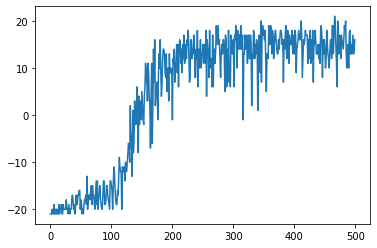

In [ ]:
plt.plot(scores)
plt.show()